# Imports

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.metrics import precision_score, recall_score, f1_score

# Data Loading & PreProcessing

In [ ]:
# Transformations for data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),  # To tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# CIFAR-10 training and testing datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Verify
print(f"Full Training set size: {len(train_dataset)}")
print(f"Full Testing set size: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Full Training set size: 50000
Full Testing set size: 10000


## Creating the Data Loader

In [ ]:
# Batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Verify
for images, labels in train_loader:
    print(f"Batch Images Shape: {images.shape}")  # Should be (64, 3, 32, 32)
    print(f"Batch Labels Shape: {labels.shape}")  # Should be (64,)
    break

Batch Images Shape: torch.Size([64, 3, 32, 32])
Batch Labels Shape: torch.Size([64])


# Base CNN Model

## Creation

In [4]:
# Define the baseline CNN model
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Output: (32, 32, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output: (64, 32, 32)
        self.pool = nn.MaxPool2d(2, 2)  # Output: (64, 16, 16)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512)  # Flatten and connect
        self.fc2 = nn.Linear(512, 10)  # Output 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training & Evaluation Loop

In [31]:
# Training function
def train_model_cnn(model, train_loader, criterion, optimizer, device, epochs):
    model.train()
    epoch_losses = []  # Store the average loss for each epoch
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")
        
    return epoch_losses


# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return(accuracy)

## Training and Evaluation

In [ ]:
# Initialize the model and params
baseCNN = BaselineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseCNN.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseCNN = baseCNN.to(device)

# Train
epoch_loss_base = train_model_cnn(baseCNN, train_loader, criterion, optimizer, device, epochs=50)

# Evaluate
evaluate_model(baseCNN, test_loader, device)

Epoch 1/50, Loss: 1.4941
Epoch 2/50, Loss: 1.1281
Epoch 3/50, Loss: 1.0005
Epoch 4/50, Loss: 0.9272
Epoch 5/50, Loss: 0.8740
Epoch 6/50, Loss: 0.8329
Epoch 7/50, Loss: 0.7955
Epoch 8/50, Loss: 0.7693
Epoch 9/50, Loss: 0.7419
Epoch 10/50, Loss: 0.7183
Epoch 11/50, Loss: 0.7031
Epoch 12/50, Loss: 0.6809
Epoch 13/50, Loss: 0.6650
Epoch 14/50, Loss: 0.6526
Epoch 15/50, Loss: 0.6335
Epoch 16/50, Loss: 0.6236
Epoch 17/50, Loss: 0.6170
Epoch 18/50, Loss: 0.6058
Epoch 19/50, Loss: 0.5997
Epoch 20/50, Loss: 0.5912
Epoch 21/50, Loss: 0.5766
Epoch 22/50, Loss: 0.5720
Epoch 23/50, Loss: 0.5636
Epoch 24/50, Loss: 0.5541
Epoch 25/50, Loss: 0.5451
Epoch 26/50, Loss: 0.5447
Epoch 27/50, Loss: 0.5362
Epoch 28/50, Loss: 0.5290
Epoch 29/50, Loss: 0.5227
Epoch 30/50, Loss: 0.5237
Epoch 31/50, Loss: 0.5151
Epoch 32/50, Loss: 0.5062
Epoch 33/50, Loss: 0.5026
Epoch 34/50, Loss: 0.5016
Epoch 35/50, Loss: 0.4928
Epoch 36/50, Loss: 0.4925
Epoch 37/50, Loss: 0.4806
Epoch 38/50, Loss: 0.4757
Epoch 39/50, Loss: 0.

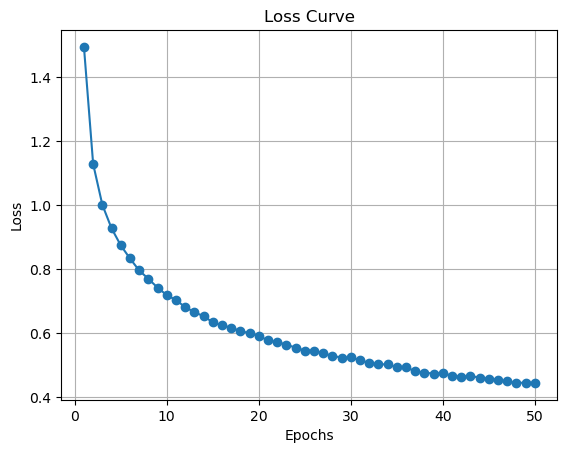

In [7]:
plt.plot(range(1, len(epoch_loss_base) + 1), epoch_loss_base, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

# Transfer Learning

## With Frozen

In [8]:
# Load a pre-trained ResNet model
resnet_freeze = models.resnet18(pretrained=True)

for param in resnet_freeze.parameters():
    param.requires_grad = False

# Modify the final layer to output 10 classes
num_classes = 10
resnet_freeze.fc = nn.Linear(resnet_freeze.fc.in_features, num_classes)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match ImageNet
])

c:\Users\dafel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dafel\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def train_model_transfer(model, train_loader, criterion, optimizer, device, epochs):
    model.train()  # Set the model to training mode
    epoch_losses = []  # List to store epoch losses

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    return epoch_losses

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_freeze.parameters(), lr=.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train
epoch_losses_transfer_frozen = train_model_transfer(resnet_freeze, train_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20, Loss: 2.1151
Epoch 2/20, Loss: 1.8646
Epoch 3/20, Loss: 1.7951
Epoch 4/20, Loss: 1.7543
Epoch 5/20, Loss: 1.7323
Epoch 6/20, Loss: 1.7230
Epoch 7/20, Loss: 1.7110
Epoch 8/20, Loss: 1.6933
Epoch 9/20, Loss: 1.6897
Epoch 10/20, Loss: 1.6915
Epoch 11/20, Loss: 1.6805
Epoch 12/20, Loss: 1.6816
Epoch 13/20, Loss: 1.6767
Epoch 14/20, Loss: 1.6730
Epoch 15/20, Loss: 1.6720
Epoch 16/20, Loss: 1.6666
Epoch 17/20, Loss: 1.6672
Epoch 18/20, Loss: 1.6591
Epoch 19/20, Loss: 1.6573
Epoch 20/20, Loss: 1.6681


In [11]:
evaluate_model(resnet_freeze, test_loader, device)

Accuracy: 41.67%


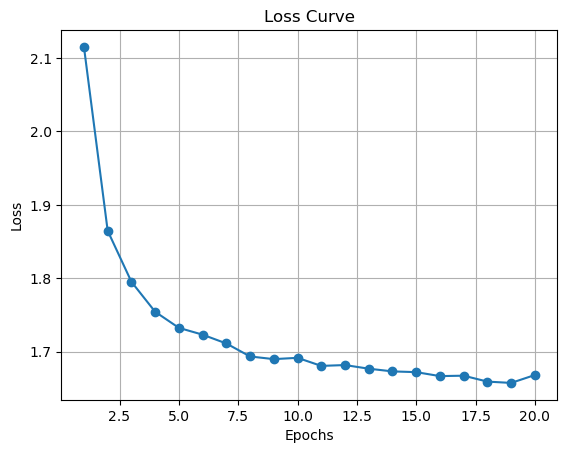

In [12]:
plt.plot(range(1, len(epoch_losses_transfer_frozen) + 1), epoch_losses_transfer_frozen, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

## Unfrozen

In [13]:
# Load a pre-trained ResNet model
resnet_unfrozen = models.resnet18(pretrained=True)

for param in resnet_unfrozen.parameters():
    param.requires_grad = True

# Modify the final layer to output 10 classes
num_classes = 10
resnet_unfrozen.fc = nn.Linear(resnet_unfrozen.fc.in_features, num_classes)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match ImageNet
])

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(resnet_unfrozen.parameters(), lr=.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train
epoch_losses_transfer_unfrozen = train_model_transfer(resnet_unfrozen, train_loader, criterion, optimizer, device, epochs=20)


Epoch 1/20, Loss: 1.1484
Epoch 2/20, Loss: 0.7757
Epoch 3/20, Loss: 0.6625
Epoch 4/20, Loss: 0.5917
Epoch 5/20, Loss: 0.5458
Epoch 6/20, Loss: 0.5035
Epoch 7/20, Loss: 0.4705
Epoch 8/20, Loss: 0.4389
Epoch 9/20, Loss: 0.4143
Epoch 10/20, Loss: 0.3838
Epoch 11/20, Loss: 0.3692
Epoch 12/20, Loss: 0.3509
Epoch 13/20, Loss: 0.3319
Epoch 14/20, Loss: 0.3165
Epoch 15/20, Loss: 0.3012
Epoch 16/20, Loss: 0.2896
Epoch 17/20, Loss: 0.2741
Epoch 18/20, Loss: 0.2669
Epoch 19/20, Loss: 0.2561
Epoch 20/20, Loss: 0.2443


In [15]:
evaluate_model(resnet_unfrozen, test_loader, device)

Accuracy: 85.76%


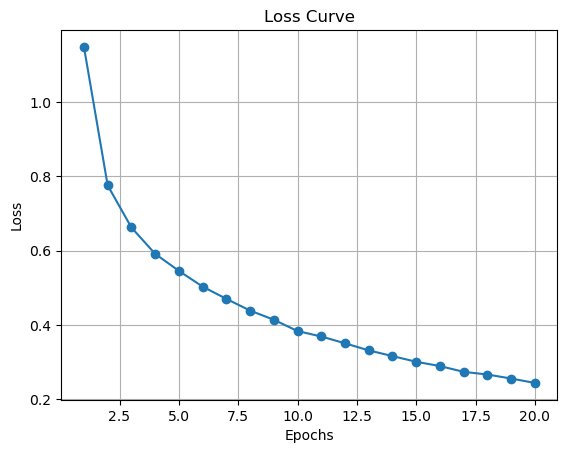

In [36]:
plt.plot(range(1, len(epoch_losses_transfer_unfrozen) + 1), epoch_losses_transfer_unfrozen, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

# Dropout

In [16]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # 64 channels, 8x8 feature map size
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes in CIFAR-10

        # Dropout
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Correctly handle batch size

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
# Initialize parameters
dropCNN = CNNWithDropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dropCNN.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropCNN = dropCNN.to(device)

# Train
epoch_loss_drop = train_model_cnn(dropCNN, train_loader, criterion, optimizer, device, epochs=50)

# Evaluate
evaluate_model(dropCNN, test_loader, device)

Epoch 1/50, Loss: 1.6065
Epoch 2/50, Loss: 1.2719
Epoch 3/50, Loss: 1.1297
Epoch 4/50, Loss: 1.0506
Epoch 5/50, Loss: 0.9933
Epoch 6/50, Loss: 0.9564
Epoch 7/50, Loss: 0.9302
Epoch 8/50, Loss: 0.9043
Epoch 9/50, Loss: 0.8884
Epoch 10/50, Loss: 0.8610
Epoch 11/50, Loss: 0.8508
Epoch 12/50, Loss: 0.8362
Epoch 13/50, Loss: 0.8167
Epoch 14/50, Loss: 0.8138
Epoch 15/50, Loss: 0.8046
Epoch 16/50, Loss: 0.7890
Epoch 17/50, Loss: 0.7771
Epoch 18/50, Loss: 0.7666
Epoch 19/50, Loss: 0.7654
Epoch 20/50, Loss: 0.7551
Epoch 21/50, Loss: 0.7560
Epoch 22/50, Loss: 0.7429
Epoch 23/50, Loss: 0.7394
Epoch 24/50, Loss: 0.7358
Epoch 25/50, Loss: 0.7264
Epoch 26/50, Loss: 0.7239
Epoch 27/50, Loss: 0.7119
Epoch 28/50, Loss: 0.7131
Epoch 29/50, Loss: 0.7012
Epoch 30/50, Loss: 0.7007
Epoch 31/50, Loss: 0.6966
Epoch 32/50, Loss: 0.6898
Epoch 33/50, Loss: 0.6893
Epoch 34/50, Loss: 0.6820
Epoch 35/50, Loss: 0.6807
Epoch 36/50, Loss: 0.6766
Epoch 37/50, Loss: 0.6771
Epoch 38/50, Loss: 0.6708
Epoch 39/50, Loss: 0.

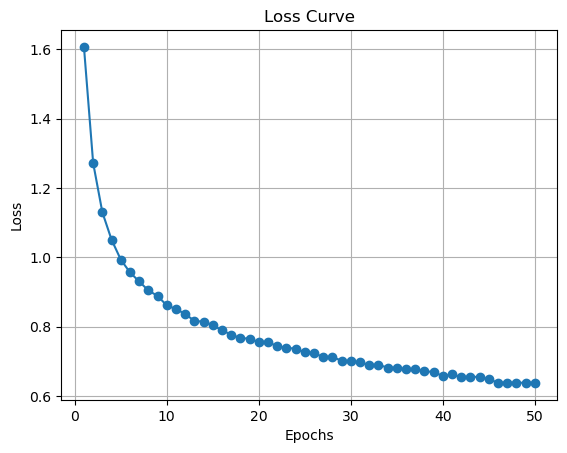

In [19]:
plt.plot(range(1, len(epoch_loss_drop) + 1), epoch_loss_drop, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.grid()
plt.show()

# Visuals

In [27]:
models = {
    "baseCNN": baseCNN,
    "resnet_freeze": resnet_freeze,
    "resnet_unfrozen": resnet_unfrozen,
    "dropCNN": dropCNN
}

## Training vs Testing

Accuracy: 85.32%
Accuracy: 79.57%
Accuracy: 42.97%
Accuracy: 41.67%
Accuracy: 93.81%
Accuracy: 85.76%
Accuracy: 80.43%
Accuracy: 77.39%


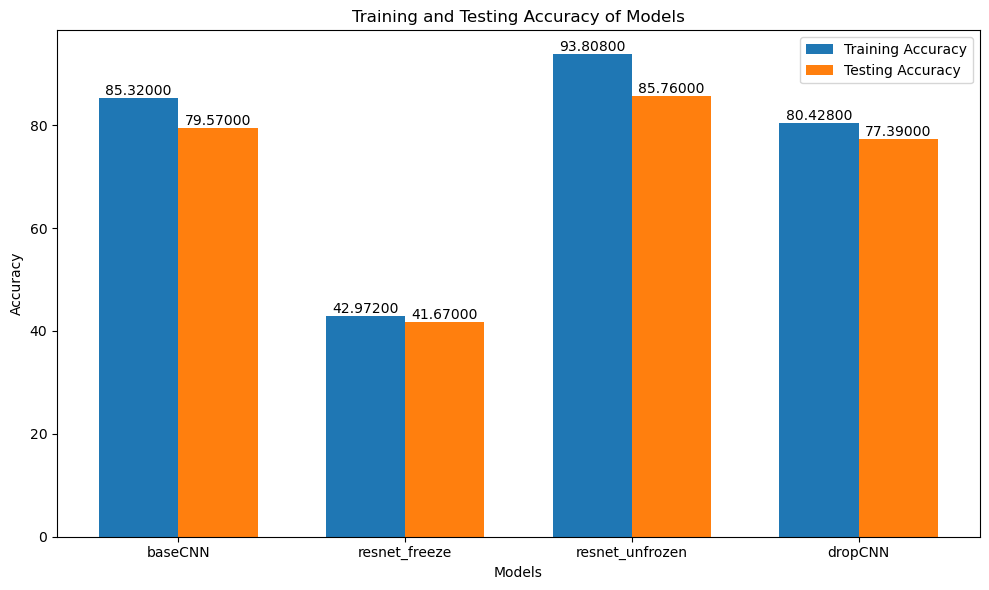

In [24]:
# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Calculate accuracies for each model
for model_name, model in models.items():
    model.to(device)
    model.eval()
    train_acc = evaluate_model(model, train_loader, device)
    test_acc = evaluate_model(model, test_loader, device)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

x = np.arange(len(models))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

# Training and Testing bars
bars1 = ax.bar(x - bar_width / 2, train_accuracies, bar_width, label="Training Accuracy")
bars2 = ax.bar(x + bar_width / 2, test_accuracies, bar_width, label="Testing Accuracy")

# Add values above the bars
for bar in bars1:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f"{height:.5f}", ha="center", va="bottom"
    )
for bar in bars2:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f"{height:.5f}", ha="center", va="bottom"
    )

ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("Training and Testing Accuracy of Models")
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend()
plt.tight_layout()
plt.show()

## All Test Metrics

Accuracy: 0.80%
Accuracy: 0.42%
Accuracy: 0.86%
Accuracy: 0.77%


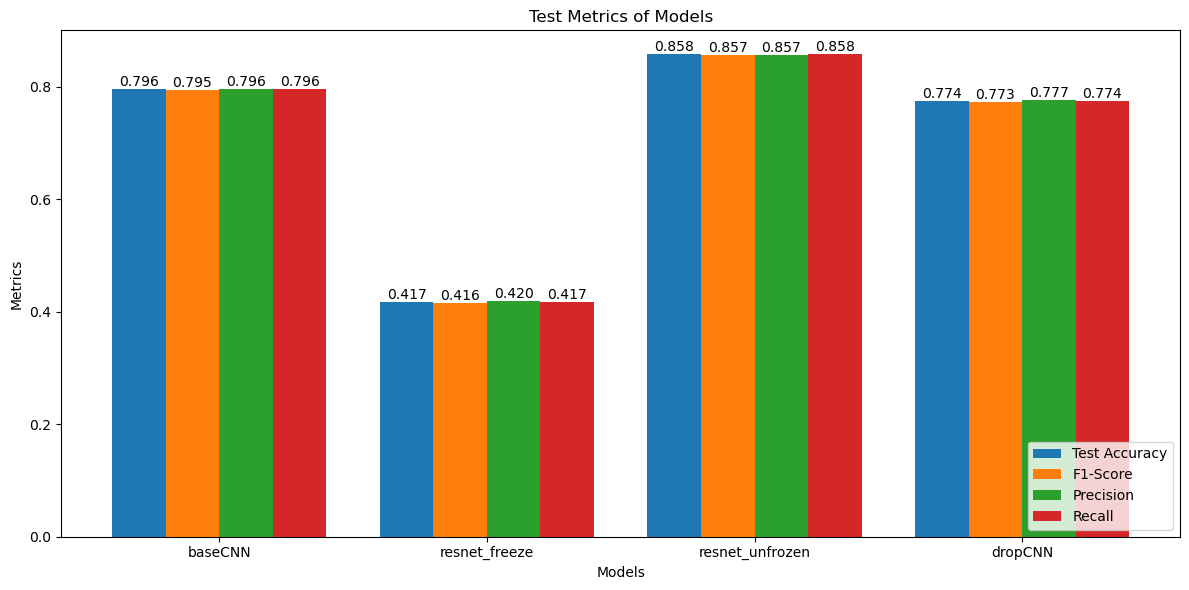

In [ ]:
# Initialize lists to store metrics
test_accuracies = []
test_f1_scores = []
test_precisions = []
test_recalls = []

# Calculate metrics for each model
for model_name, model in models.items():
    model.to(device)
    model.eval()
    accuracy = evaluate_model(model, test_loader, device)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    test_accuracies.append(accuracy)
    test_f1_scores.append(f1)
    test_precisions.append(precision)
    test_recalls.append(recall)

x = np.arange(len(models))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Bars for each metric
bars1 = ax.bar(x - 1.5 * bar_width, test_accuracies, bar_width, label="Test Accuracy")
bars2 = ax.bar(x - 0.5 * bar_width, test_f1_scores, bar_width, label="F1-Score")
bars3 = ax.bar(x + 0.5 * bar_width, test_precisions, bar_width, label="Precision")
bars4 = ax.bar(x + 1.5 * bar_width, test_recalls, bar_width, label="Recall")

# Add values above the bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha="center", va="bottom"
        )

ax.set_xlabel("Models")
ax.set_ylabel("Metrics")
ax.set_title("Test Metrics of Models")
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()